## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction 

In this project, I try to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [453]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` 
a. Read in the dataset and take a look at the top few rows here:

In [454]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [455]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [456]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [457]:
df.query('converted == 1').user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [458]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').user_id.nunique()

3893

f. Do any of the rows have missing values?

In [459]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, I cannot be sure if this row truly received the new or old page.  

a. Remove the rows where treatment does not match with new_page or control does not match with old_page

In [460]:
df.user_id.count() #290585

294478

In [461]:
#remove the rows where treatment does not match with new_page or control does not match with old_page
id= df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').index
df2 = df.drop(id, axis = 0)

In [462]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [463]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [464]:
df2[df2.duplicated(['user_id'])].index

Int64Index([2893], dtype='int64')

c. What is the row information for the repeat **user_id**? 

In [465]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [466]:
df2.drop_duplicates('user_id', inplace= True)

In [467]:
df2.count()

user_id         290584
timestamp       290584
group           290584
landing_page    290584
converted       290584
dtype: int64

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [468]:
df2.query('landing_page == "old_page" or landing_page == "new_page"').converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [469]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [470]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [471]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

There is no sufficient evidence to conclude that the new treatment page leads to more conversions because the probabilites that an individual converted is similar for both the control and treatment groups. Furthermore, an A/B test can help us know if the observed difference in the probabilities is statistically significant or not.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} <= p_{old} $$
$$H_1: p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [472]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [473]:
p_new= df2.query('landing_page == "old_page" or landing_page == "new_page"').converted.mean()

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [474]:
p_old = df2.query('landing_page == "old_page" or landing_page == "new_page"').converted.mean()

c. What is $n_{new}$, the number of individuals in the treatment group?

In [475]:
treat_df = df2.query('landing_page == "new_page"')
n_new = treat_df.user_id.count()

d. What is $n_{old}$, the number of individuals in the control group?

In [476]:
control_df = df2.query('landing_page == "old_page"')
n_old= control_df.user_id.nunique()

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [477]:
new_page_converted= np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [478]:
old_page_converted =np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [479]:
obs_diff= new_page_converted.mean()- old_page_converted.mean()
obs_diff

-0.00036666187529797722

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [480]:
p_diffs = []

for i in range(10000):
    new_page_converted= np.random.binomial(1, p_new, n_new)
    old_page_converted =np.random.binomial(1, p_old, n_old)
    new_mean= new_page_converted.mean()
    old_mean= old_page_converted.mean()
    p_diffs.append(new_mean - old_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

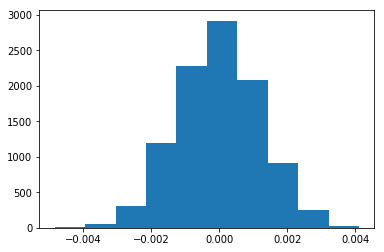

In [481]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [482]:
actual_diff = df2.query('landing_page == "new_page"').converted.mean() - df2.query('landing_page == "old_page"').converted.mean()
actual_diff

-0.0015782389853555567

In [483]:
p_diffs = np.array(p_diffs)
(p_diffs>actual_diff).mean()

0.9002

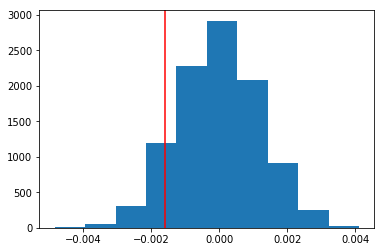

In [484]:
plt.hist(p_diffs)
plt.axvline(actual_diff, color = 'red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

I calculated the proportion of p_diffs with a value greater than the actual difference. This value is called the p-value. A p-value of 0.90 implies that the difference between the treatment and control groups is not statistically significant.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [485]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

convert_old = df2.query('landing_page == "old_page" and converted== 1').user_id.count()
convert_new = df2.query('landing_page == "new_page" and converted ==1').user_id.count()
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_new = df2.query('landing_page == "new_page"').user_id.count()
print('Converted:', convert_old, convert_new)
print('Numbers:', n_old, n_new)

Converted: 17489 17264
Numbers: 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [486]:
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')


(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Z-score is -1.31. The critical value for a 95% confidence value is 1.96, hence, since this value is lower, we fail to reject the null hypothesis.
The findings agrees with the result in j, where I also fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [487]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [488]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']]= pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [489]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result= log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [490]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:37:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value is 0.19, which implies that the coefficient of ab_page is not statistically significant.

Part II hypothesis:

$$H_0: p_{new} <= p_{old} $$
$$H_1: p_{new} > p_{old} $$

Part III hypothesis:
$$H_0: p_{new} = p_{old} $$
$$H_1: p_{new} \neq p_{old} $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is good idea to consider other factors in the regression model because there are other factors that can affect if an individual is converted or not. For example, demographic factors ccould affect if the individual converts or not. In addition, the duration of the time an individual spends on the site, or number of times an individual visits the e-commerce site can be added to the regression model.

The disadvantages that can arise are issues like:
Multicollinearity,
non-linear relationship between the response and predictor variables,
correlation of the error,
non-constant variance and 
outliers


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [491]:
country_df= pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [492]:
#countries in data_set
country_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [493]:
#merge on user_id
df_new= df2.join(country_df.set_index('user_id'), on = 'user_id')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [494]:
df_new[['CA', 'UK', 'US']]= pd.get_dummies(df_new['country'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [495]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA']])
result= log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:37:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

It seems that adding the countries did affect the results. The p-values for ab_page as well as for the countries are not statistically significant

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [496]:
df_new['UK_ab_page'] = df_new['ab_page'] *df_new['UK']
df_new['CA_ab_page']= df_new['ab_page'] * df_new['CA']

In [497]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])
result= log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 22 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:37:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

Similar results like above.
Including the interaction term did affect the results. The p-values for ab_page as well as for the countries and interactions are not statistically significant

## Conclusion
The aim of this project is to perform an A/B test for an e-commerce company to determine if implementing a new page increases the number of users who decide to pay for their products. The goal is to help the company decide if they should implement the new page.

In part II - A/B test, The null hypothesis is that the old page is more effective or as effective as the new page in converting the company's users. The results from the A/B test suggests that I cannot reject the null hypothesis.

In part III- regressions, I fit three logistic regressions which suggest similar results as above. Including the users' countries did not change the result.

In conclusion, I can recommend to the company that the new page should not be implemented. There is no practical significance for implementing the new page as the cost involved with launching the new page does not translate into more users deciding to buy their products.



In [498]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0